## Mini-projeto de Redes Neurais
### Prever o preço da Bitcoin usando LSTM

#### Grupo  1
- Maria Luísa Leandro de Lima (mlll)
- Gabriel de Melo Evangelista (gme)
- Vinícius Sales Oliveira (vso2)

## Parâmetros a serem variados
Os parâmetros abaixo serão variados dentro dos seguintes intervalos:

* Tamanho da Janela/Sequência
* Algoritmo de Aprendizagem
* Número de Camadas
* Taxa de aprendizagem
* Dropout
* Batch Size

#### Imports

Abaixo realizamos não só os imports de pacotes como também deixamos fixa a semente de aleatoriedade das bibliotecas matemáticas que usamos afim de aumentar a reprodutibilidade dos experimentos e realizamos a ligação entre o Google Drive e o código para que o nosso dataset, que está no Google Drive, possa ser acessado diretamente pelo Google Colab.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [ ]:
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
SEQ_LEN = 250
WINDOW_SIZE = SEQ_LEN - 1
UNITS = 10
DROPOUT = 0.1
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE=0.001
VERBOSE = 0
OPT = tf.keras.optimizers.Adam

### Data formatting

Abaixo usamos a função ```read_csv``` da biblioteca pandas para ler o arquivo csv que contém os dados a serem utilizados. Usamos em seguida o método ```iloc[::-1]``` com o objetivo de inverter a ordem das linhas do dataset, para que ele fique em ordem ascendente de data, como o requerido pelo professor.

In [ ]:
df = pd.read_csv("drive/MyDrive/btc.csv").iloc[::-1] 

In [ ]:
print(df.shape)
df.head()

(1273, 8)


,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
1272,12/1/2014,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1271,12/2/2014,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1270,12/3/2014,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1269,12/4/2014,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1268,12/5/2014,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


#### Data scaling

Normalizar os dados é importante para que valores que possuem uma magnitude muito grande não possam influenciar mais a decisão de um algoritmo em relação a outros dados. Para este mini-projeto, iremos apenas utilizar a coluna com valor de fechamento do Bitcoin.

In [ ]:
scaler = MinMaxScaler()
close_price = df['Close'].values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

### Funções

Criamos funções auxiliares para criação das sequências e separação dos datasets de treino e teste para a rede LSTM.

A função to_sequences separa os dados de entrada em sequências de tamanho seq_len.

In [ ]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    
    return np.array(d)

A função preprocess primeiramente cria as sequências dos dados e separa os dados para treino e teste.

In [ ]:
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

### Train and test datasets

Aqui é chamada a função para criação dos datasets de treino e teste.

In [ ]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.8)

In [ ]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(818, 1)
(818, 249, 1)
(205, 1)
(205, 249, 1)


### Preliminary Modeling

Primeiramente vamos comparar o desempenho de dois modelos simples e bem parecidos: o LSTM e o LSTM Bidirecional, onde ocorre o treinamento da rede nos dois sentidos, para a frente e para trás.

In [ ]:
model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, X_train.shape[-1]), dropout=DROPOUT))
model_LSTM.add(tf.keras.layers.Dense(1, activation='linear'))
model_LSTM.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE), 
    loss="mse")

In [ ]:
model_LSTM_BI = tf.keras.Sequential()
model_LSTM_BI.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, X_train.shape[-1]), dropout=DROPOUT)))
model_LSTM_BI.add(tf.keras.layers.Dense(1, activation='linear'))
model_LSTM_BI.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE), 
    loss="mse")

#### Model training

In [ ]:
history_LSTM = model_LSTM.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    validation_split=0.2)

In [ ]:
history_LSTM_BI = model_LSTM_BI.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    validation_split=0.2)

#### Model Evaluation

Foi criada uma função para visualização dos resultados do treinamento. Nessa função, são criados o gráfico de loss do treinamento e da validação, o gráfico da predição do valor do BTC e calcula-se o RMSE de treino e teste.

In [ ]:
def model_evaluation(history, model, scaler, X_test, X_train, y_train, y_test):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'upper left')
  plt.show()

  y_hat = model.predict(X_test)
  y_t = model.predict(X_train)

  y_test_inverse = scaler.inverse_transform(y_test)
  y_hat_inverse = scaler.inverse_transform(y_hat)
 
  plt.plot(y_test_inverse, label='Actual Price', color = 'green')
  plt.plot(y_hat_inverse, label='Predicted Price', color = 'red')

  plt.title('Bitcoin price prediction')
  plt.xlabel('Time [days]')
  plt.ylabel('Price')

  ## adicionar legenda com os parametros atuais

  trainScore = math.sqrt(mean_squared_error(y_train[0], y_t[0]))
  print('Train Score: %.4f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test[0], y_hat[0]))
  print('Test Score: %.4f RMSE' % (testScore))
  
  plt.show()

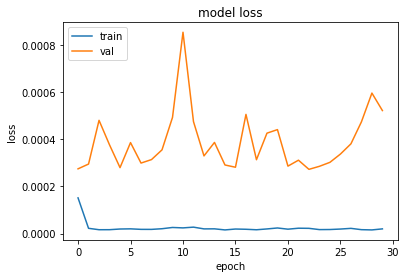

Train Score: 0.0045 RMSE
Test Score: 0.0532 RMSE


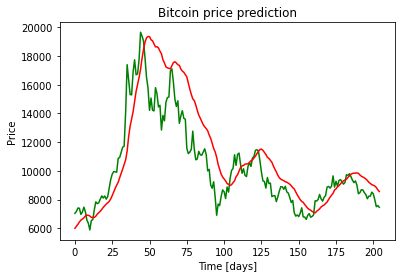

In [ ]:
model_evaluation(history_LSTM, model_LSTM, scaler, X_test, X_train, y_train, y_test)

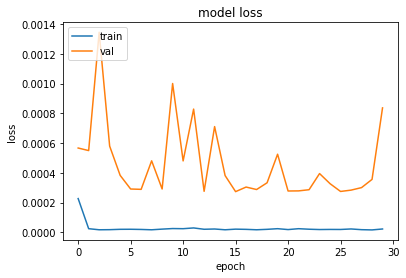

Train Score: 0.0056 RMSE
Test Score: 0.0705 RMSE


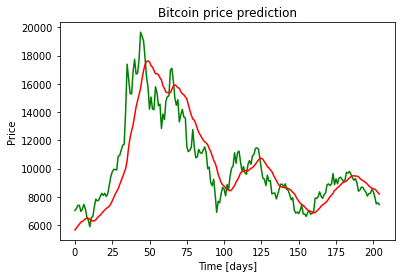

In [ ]:
model_evaluation(history_LSTM_BI, model_LSTM_BI, scaler, X_test, X_train, y_train, y_test)

### Experimentation
Dentre os dois modelos criados, não houve muita diferença no RMSE. Porém, o gráfico de loss mostrou que o modelo LSTM unidirecional pode estar passando por overfitting. 

Apesar disso, pela simplicidade vamos optar pelo modelo LSTM unidirecional.

#### Algoritmos de Aprendizagem

Nesse experimento, investigamos a performance de uma LSTM simples para os três algoritmos de aprendizagem mais conhecidos:


 - Gradiente Descendente Estocástico
 - RMSProp
 - Adam

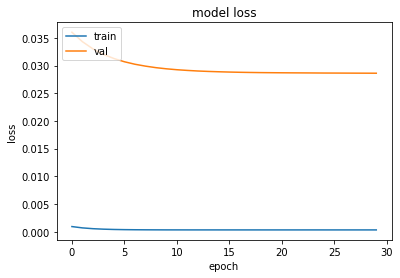

Train Score: 0.0191 RMSE
Test Score: 0.3359 RMSE


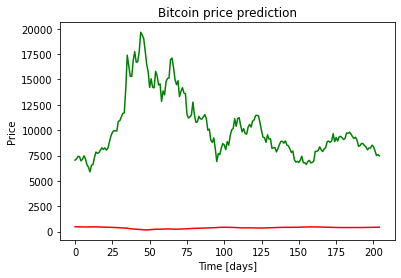

Optimizer:  <class 'keras.optimizer_v2.gradient_descent.SGD'>
-------------------------------------------------------------------------------------------------


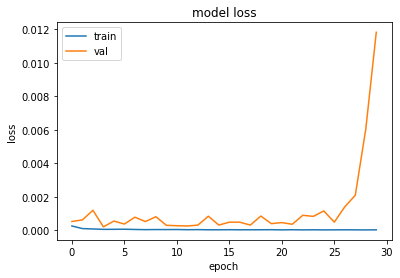

Train Score: 0.0054 RMSE
Test Score: 0.2099 RMSE


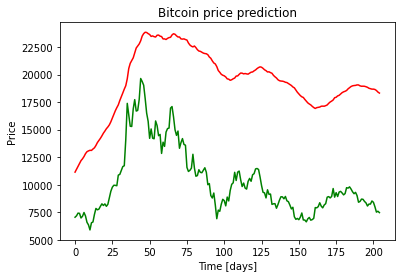

Optimizer:  <class 'keras.optimizer_v2.rmsprop.RMSprop'>
-------------------------------------------------------------------------------------------------


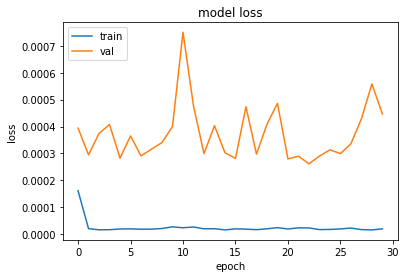

Train Score: 0.0041 RMSE
Test Score: 0.0497 RMSE


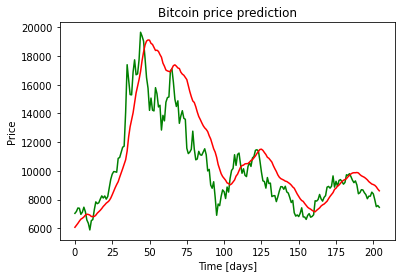

Optimizer:  <class 'keras.optimizer_v2.adam.Adam'>
-------------------------------------------------------------------------------------------------


In [ ]:
opts = [tf.keras.optimizers.SGD,tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adam]
for opt in opts:
  optimizer = opt(learning_rate=LEARNING_RATE)

  model_LSTM_O = tf.keras.Sequential()
  model_LSTM_O.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, X_train.shape[-1]), dropout=DROPOUT))
  model_LSTM_O.add(tf.keras.layers.Dense(1, activation='linear'))
  model_LSTM_O.compile(
      optimizer=optimizer, 
      loss="mse")
  
  history_LSTM_O = model_LSTM_O.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=30, 
    verbose=VERBOSE, 
    validation_split=0.2)
  model_evaluation(history_LSTM_O, model_LSTM_O, scaler, X_test, X_train, y_train, y_test)
  print('Optimizer: ', opt)
  print('-------------------------------------------------------------------------------------------------')


##### Análise Resultados

Como esperado, o melhor algoritmo de aprendizagem foi o Adam, visto que ele incorpora e estende as melhores características do RMSProp e SGD.

In [ ]:
OPT = tf.keras.optimizers.Adam

#### Taxa de Aprendizagem

Nesse experimento, iremos variar a taxa de aprendizagem em 25%, 50%, 200%, 400% do valor 0.001 padrão definido anteriormente.

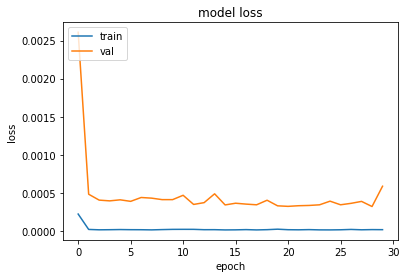

Train Score: 0.0023 RMSE
Test Score: 0.0654 RMSE


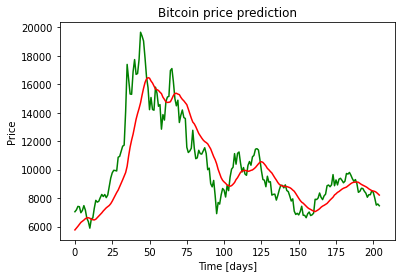

LEARNING RATE =  0.00025
-------------------------------------------------------------------------------------------------


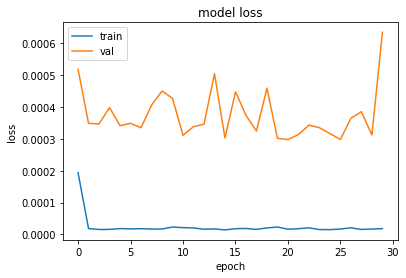

Train Score: 0.0037 RMSE
Test Score: 0.0635 RMSE


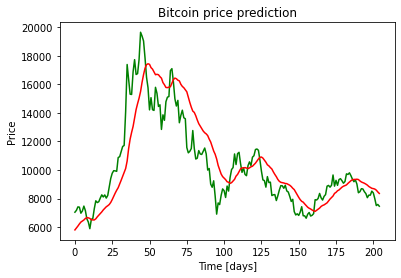

LEARNING RATE =  0.0005
-------------------------------------------------------------------------------------------------


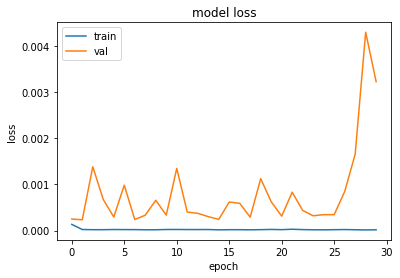

Train Score: 0.0020 RMSE
Test Score: 0.1043 RMSE


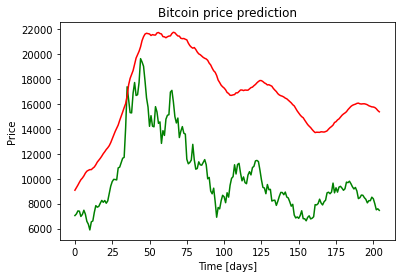

LEARNING RATE =  0.002
-------------------------------------------------------------------------------------------------


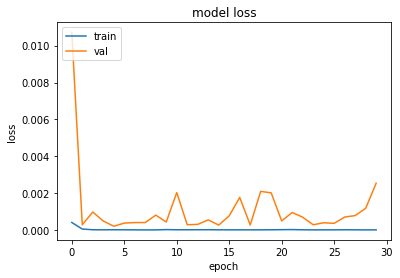

Train Score: 0.0033 RMSE
Test Score: 0.0649 RMSE


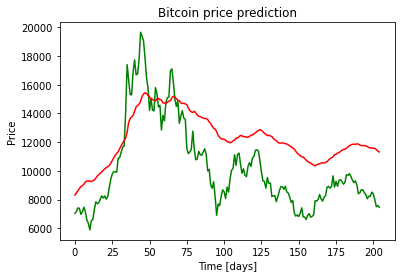

LEARNING RATE =  0.004
-------------------------------------------------------------------------------------------------


In [ ]:
lrs = [LEARNING_RATE * x for x in [0.25, 0.5, 2, 4]]
for lr in lrs:
  optimizer = OPT(learning_rate = lr)

  model_LSTM_LR = tf.keras.Sequential()
  model_LSTM_LR.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, X_train.shape[-1]), dropout=DROPOUT))
  model_LSTM_LR.add(tf.keras.layers.Dense(1, activation='linear'))
  model_LSTM_LR.compile(
      optimizer=optimizer, 
      loss="mse")
  history_LSTM_LR = model_LSTM_LR.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    validation_split=0.2)
  model_evaluation(history_LSTM_LR, model_LSTM_LR, scaler, X_test, X_train, y_train, y_test)
  print('LEARNING RATE = ', lr)
  print('-------------------------------------------------------------------------------------------------')


##### Análise Resultados

Nesse experimentos, vemos a necessidade do fine tuning da taxa de aprendizagem.

Uma taxa de aprendizagem pequena pode nos dar bons resultados, mas pode ficar presa em mínimos locais sem a ajuda de otimizadores e demorar mais épocas para treinar.
Já uma taxa de aprendizado muito alta pode acarretar um overshotting e fazer o modelo não convergir, sendo um resultado desastroso.

Para o primeiro exemplo, temos uma boa performance, que poderia melhorar. Mas para os últimos, temos modelos com taxas de aprendizado muito altas, como pode ser visto na variação da curva de validation loss.

In [ ]:
LEARNING_RATE = 0.0005

#### Epochs

Vamos variar agora o número de epochs, ou vezes que o modelo irá iterar sobre o conjunto de treino. Um valor alto pode gerar overfitting, enquanto que um valor baixo pode gerar underfitting. Vamos variar no seguinte intervalo: `epochs_values = [5, 10, 20, 30]`

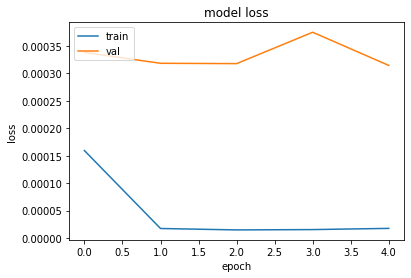

Train Score: 0.0004 RMSE
Test Score: 0.0404 RMSE


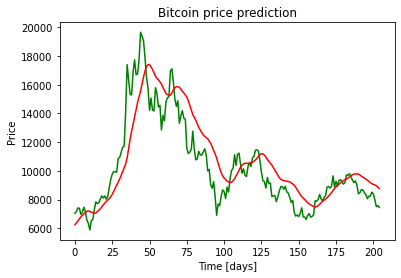

EPOCHS =  5
-------------------------------------------------------------------------------------------------


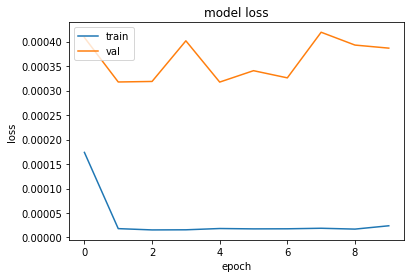

Train Score: 0.0004 RMSE
Test Score: 0.0537 RMSE


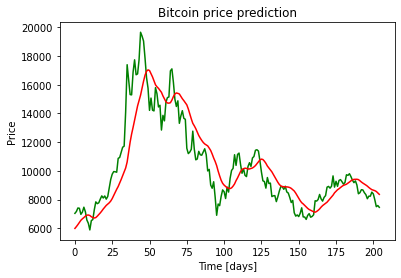

EPOCHS =  10
-------------------------------------------------------------------------------------------------


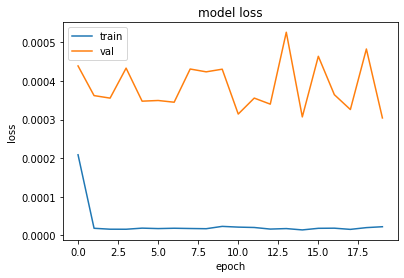

Train Score: 0.0019 RMSE
Test Score: 0.0360 RMSE


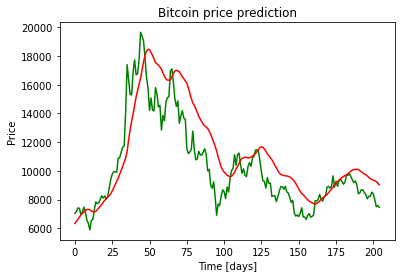

EPOCHS =  20
-------------------------------------------------------------------------------------------------


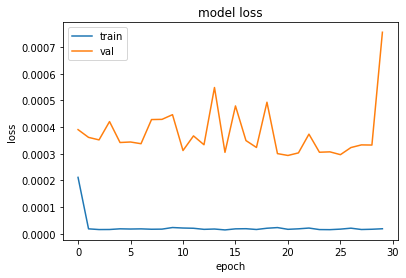

Train Score: 0.0038 RMSE
Test Score: 0.0713 RMSE


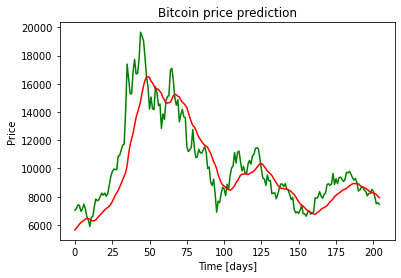

EPOCHS =  30
-------------------------------------------------------------------------------------------------


In [ ]:
epochs_values = [5, 10, 20, 30]
for epoch in epochs_values:
  model_LSTM_E = tf.keras.Sequential()
  model_LSTM_E.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, X_train.shape[-1]), dropout=DROPOUT))
  model_LSTM_E.add(tf.keras.layers.Dense(1, activation='linear'))
  model_LSTM_E.compile(
      optimizer=OPT(learning_rate = LEARNING_RATE), 
      loss="mse")
  history_LSTM_E = model_LSTM_E.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=epoch, 
    verbose=VERBOSE, 
    validation_split=0.2)
  model_evaluation(history_LSTM_E, model_LSTM_E, scaler, X_test, X_train, y_train, y_test)
  print('EPOCHS = ', epoch)
  print('-------------------------------------------------------------------------------------------------')


##### Análise Resultados

Foi observado que o número de épocas que um modelo treina pode acarretar um overfitting ou underfitting e o número de épocas ideal depende da complexidade do modelo, isto é, a quantidade de parâmetros a serem ajustados.

Para o modelo treinado, vemos que o número ideal de épocas é 10.

In [ ]:
EPOCHS = 10

#### Batch Size

Nesse experimento, investigou-se a influência do `batch_size` para a previsão. Então variamos o valor do batch size em `[8,16,32,64,128]`.



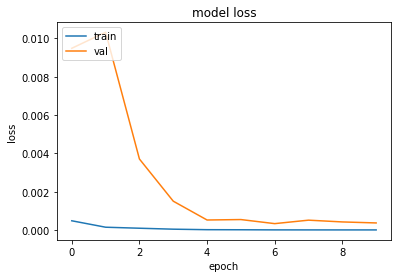

Train Score: 0.0003 RMSE
Test Score: 0.0516 RMSE


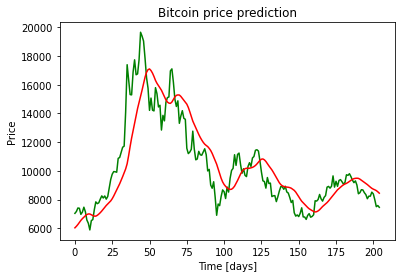

BATCH SIZE =  128
-------------------------------------------------------------------------------------------------


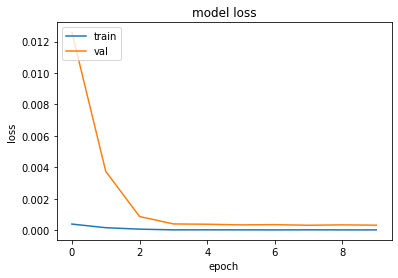

Train Score: 0.0013 RMSE
Test Score: 0.0374 RMSE


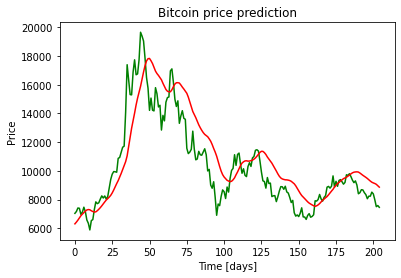

BATCH SIZE =  64
-------------------------------------------------------------------------------------------------


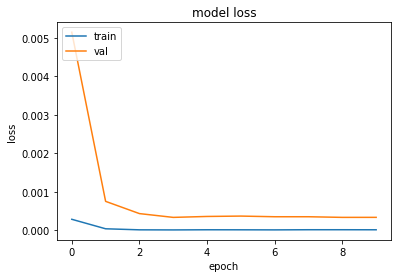

Train Score: 0.0017 RMSE
Test Score: 0.0395 RMSE


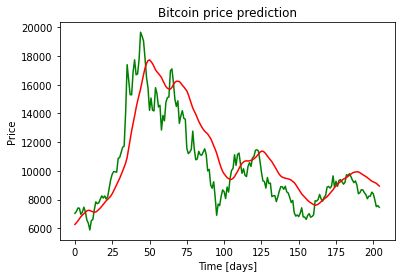

BATCH SIZE =  32
-------------------------------------------------------------------------------------------------


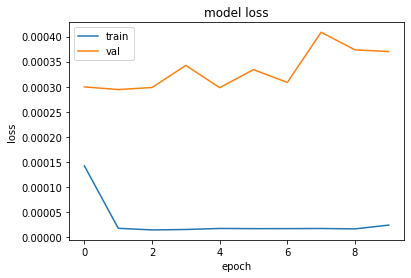

Train Score: 0.0004 RMSE
Test Score: 0.0531 RMSE


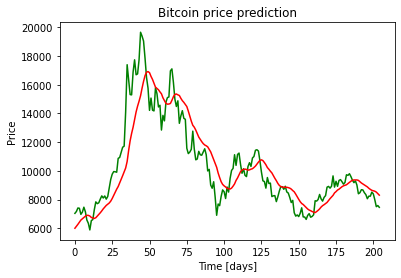

BATCH SIZE =  16
-------------------------------------------------------------------------------------------------


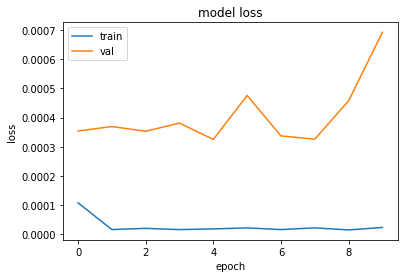

Train Score: 0.0005 RMSE
Test Score: 0.0705 RMSE


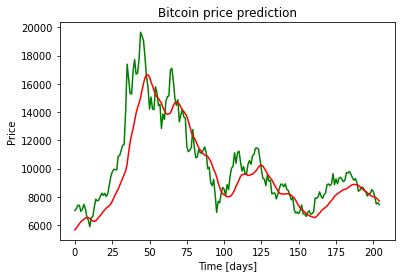

BATCH SIZE =  8
-------------------------------------------------------------------------------------------------


In [ ]:
batch_size_values = [8,16,32,64,128]
for bs in batch_size_values[::-1]:
  model_LSTM_BS = tf.keras.Sequential()
  model_LSTM_BS.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, X_train.shape[-1]), dropout=DROPOUT))
  model_LSTM_BS.add(tf.keras.layers.Dense(1, activation='linear'))
  model_LSTM_BS.compile(
      optimizer=OPT(learning_rate = LEARNING_RATE), 
      loss="mse")
  history_LSTM_BS = model_LSTM_BS.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    batch_size=bs, 
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    validation_split=0.2)
  model_evaluation(history_LSTM_BS, model_LSTM_BS, scaler, X_test, X_train, y_train, y_test)
  print('BATCH SIZE = ', bs)
  print('-------------------------------------------------------------------------------------------------')


##### Análise Resultados

Pelos testes conduzidos, vimos que quando temos um lote pequeno, temos uma maior taxa de atualização dos pesos das células da rede, podendo levar a um overfitting do conjunto de treinamento(como aconteceu perceptivelmente com os menores valores de `batch_size`. Por outro lado, o aumento diminui a taxa de atualização da rede, causando um underfitting.

In [ ]:
BATCH_SIZE = 16

#### Sequence Length

Nesse experimento, investigou-se a influência do tamanho da sequência para a previsão. Variamos o valor `sequence_lengths` em períodos de uma semana, 1 mês, 3 meses, 6 meses e um ano. logo temos `sequence_lengths = [7,30,90,180,365]`.

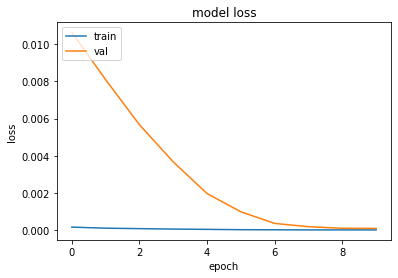

Train Score: 0.0011 RMSE
Test Score: 0.0524 RMSE


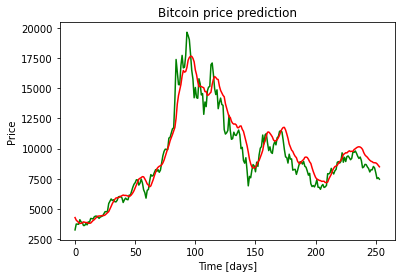

SEQUENCE LENGTH =  7
-------------------------------------------------------------------------------------------------


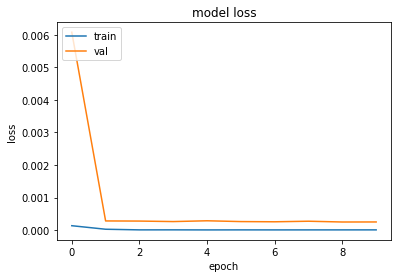

Train Score: 0.0028 RMSE
Test Score: 0.0148 RMSE


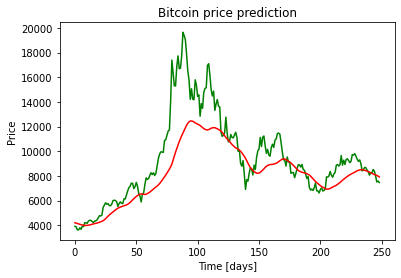

SEQUENCE LENGTH =  30
-------------------------------------------------------------------------------------------------


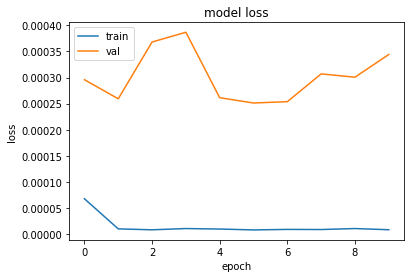

Train Score: 0.0014 RMSE
Test Score: 0.0272 RMSE


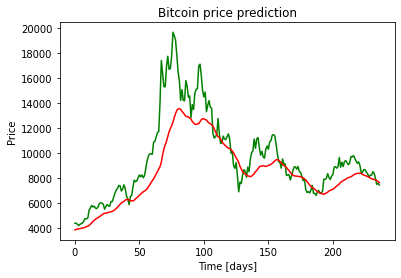

SEQUENCE LENGTH =  90
-------------------------------------------------------------------------------------------------


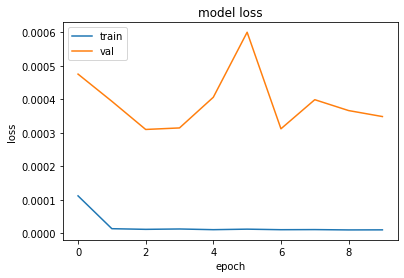

Train Score: 0.0006 RMSE
Test Score: 0.0260 RMSE


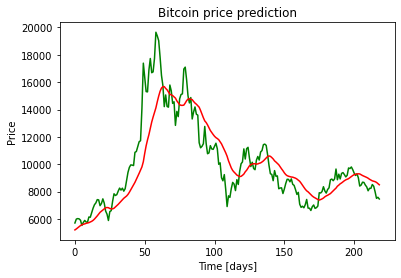

SEQUENCE LENGTH =  180
-------------------------------------------------------------------------------------------------


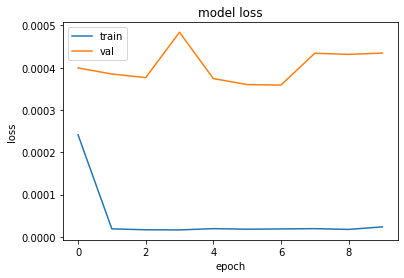

Train Score: 0.0002 RMSE
Test Score: 0.0563 RMSE


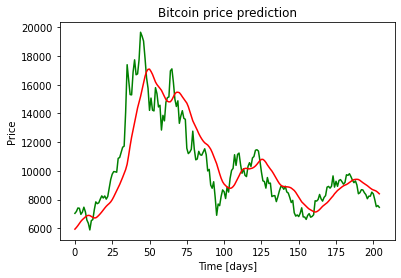

SEQUENCE LENGTH =  250
-------------------------------------------------------------------------------------------------


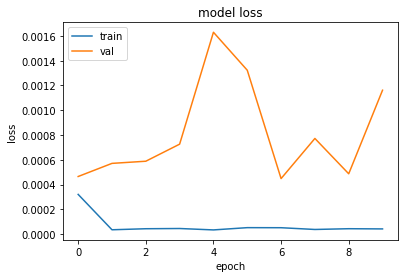

Train Score: 0.0004 RMSE
Test Score: 0.0792 RMSE


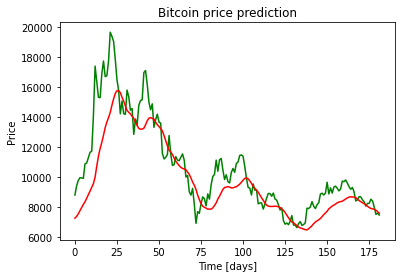

SEQUENCE LENGTH =  365
-------------------------------------------------------------------------------------------------


In [ ]:
sequence_lengths = [7,30,90,180,250,365]
for sl in sequence_lengths:
  X_train_SL, y_train_SL, X_test_SL, y_test_SL = preprocess(scaled_close, sl, train_split = 0.8)
  ws = sl - 1
  model_LSTM_SL = tf.keras.Sequential()
  model_LSTM_SL.add(tf.keras.layers.LSTM(ws, input_shape=(ws, X_train_SL.shape[-1]), dropout=DROPOUT))
  model_LSTM_SL.add(tf.keras.layers.Dense(1, activation='linear'))
  model_LSTM_SL.compile(
      optimizer=OPT(learning_rate = LEARNING_RATE), 
      loss="mse")
  
  history_LSTM_SL = model_LSTM_SL.fit(
    np.array(X_train_SL).reshape(X_train_SL.shape[0], X_train_SL.shape[1], 1), 
    y_train_SL, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    validation_split=0.2)
  
  model_evaluation(history_LSTM_SL, model_LSTM_SL, scaler, X_test_SL, X_train_SL, y_train_SL, y_test_SL)
  print('SEQUENCE LENGTH = ', sl)
  print('-------------------------------------------------------------------------------------------------')


##### Análise Resultados

Os resultados do experimento demonstram a principal característica do modelo de LSTM: Manter características relevantes em longas sequências temporais. Para esse problema, Nota-se a melhora do modelo em relação a diminuição do tamanho da janela. Vemos que o valor dos testes de validação convergem mais rápido(em menos épocas) quanto maior for a janela. Daí, temos que para janelas pequenas, podemos ter um underfitting e para janelas muito grandes, um possível overfitting.

Para a previsão, o melhor tamanho da janela foi 7.

In [ ]:
SEQ_LEN = 7
WINDOW_SIZE = SEQ_LEN - 1
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.8)


#### Dropout

Nesse experimento iremos aplicar o dropout de 0 a 0.4 com o passo de 0.1 na camada da LSTM.

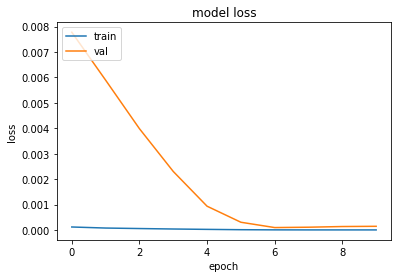

Train Score: 0.0003 RMSE
Test Score: 0.0671 RMSE


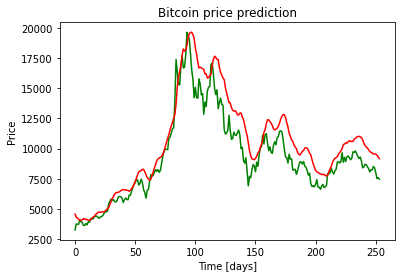

Dropout =  0.0
-------------------------------------------------------------------------------------------------


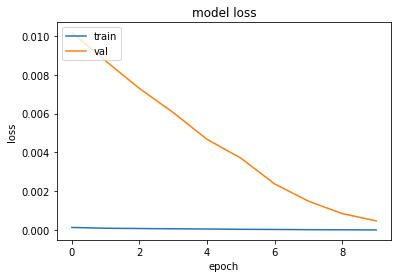

Train Score: 0.0007 RMSE
Test Score: 0.0177 RMSE


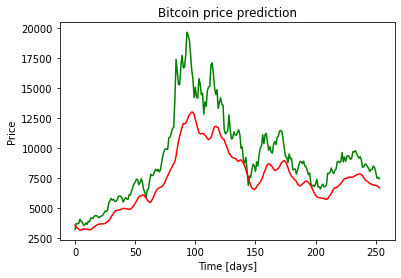

Dropout =  0.1
-------------------------------------------------------------------------------------------------


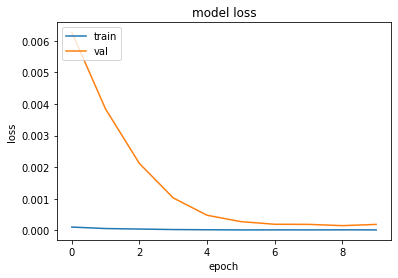

Train Score: 0.0013 RMSE
Test Score: 0.0368 RMSE


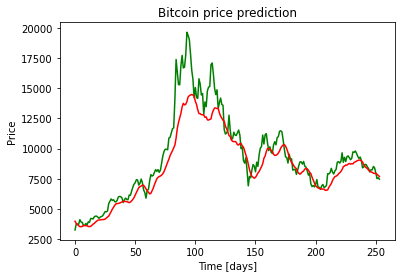

Dropout =  0.2
-------------------------------------------------------------------------------------------------


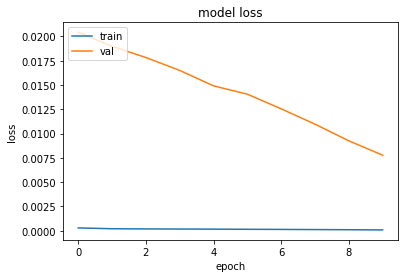

Train Score: 0.0006 RMSE
Test Score: 0.1002 RMSE


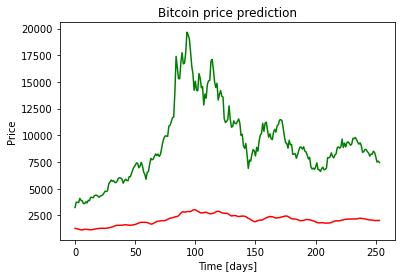

Dropout =  0.30000000000000004
-------------------------------------------------------------------------------------------------


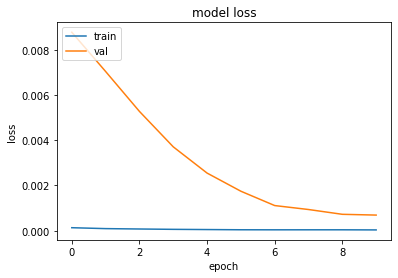

Train Score: 0.0018 RMSE
Test Score: 0.0136 RMSE


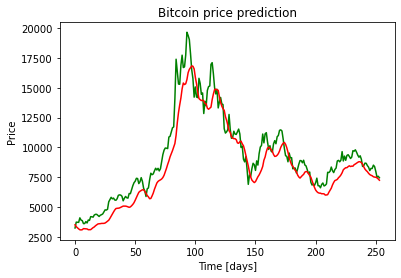

Dropout =  0.4
-------------------------------------------------------------------------------------------------


In [ ]:
for dp in range(0, 5):
  model_LSTM_DP = tf.keras.Sequential()
  model_LSTM_DP.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, X_train.shape[-1]), dropout=dp*0.1))
  model_LSTM_DP.add(tf.keras.layers.Dense(1, activation='linear'))
  model_LSTM_DP.compile(
      optimizer=OPT(learning_rate = LEARNING_RATE), 
      loss="mse")
  history_LSTM_DP = model_LSTM_DP.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,  
    verbose=VERBOSE, 
    validation_split=0.2)
  model_evaluation(history_LSTM_DP, model_LSTM_DP, scaler, X_test, X_train, y_train, y_test)
  print('Dropout = ', dp*0.1)
  print('-------------------------------------------------------------------------------------------------')


##### Análise Resultados

O experimento mostra que o aumento da taxa de dropout, em geral, diminuiu a performance do modelo. Logo, concluímos que não é um bom regularizador para esse modelo.

In [ ]:
DROPOUT = 0

### Melhor Modelo com 1 Camada

Ao longo dos experimentos foram coletados os melhores valores para parâmetro, agora um modelo com esses valores será treinado e avaliado.

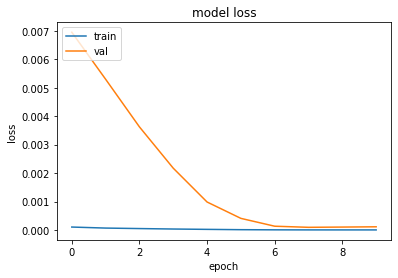

Train Score: 0.0003 RMSE
Test Score: 0.0624 RMSE


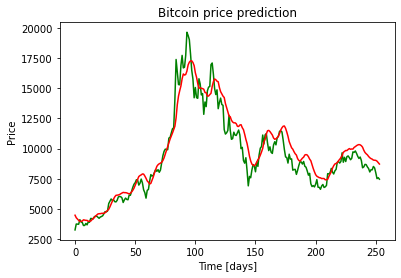

In [ ]:
bestModel_LSTM = tf.keras.Sequential()
bestModel_LSTM.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, X_train.shape[-1]), dropout=DROPOUT))
bestModel_LSTM.add(tf.keras.layers.Dense(1, activation='linear'))
bestModel_LSTM.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE), 
    loss="mse")
history_bestModel_LSTM = bestModel_LSTM.fit(
  np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
  y_train, 
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS, 
  verbose=VERBOSE, 
  validation_split=0.2)
model_evaluation(history_bestModel_LSTM, bestModel_LSTM, scaler, X_test, X_train, y_train, y_test)

#### Número de Camadas

Nesse experimento, construímos modelos com mais camadas LSTM para investigar suas implicações nesse problema.

Testamos quatro configurações:

- Com os melhores hiperparâmetros para o modelo de uma camada
- A configuração anterior e dobrando o tamanho da janela na segunda camada LSTM
- Configuração anterior e adicionando um dropout de 20% nas duas camadas LSTM
- Um modelo de 3 camadas LSTM com as duas primeiras camadas iguais à configuração anterior adicionando apenas uma camada com os melhores hiperparâmetros para o modelo de uma camada 

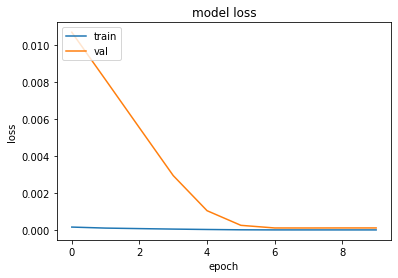

Train Score: 0.0001 RMSE
Test Score: 0.0601 RMSE


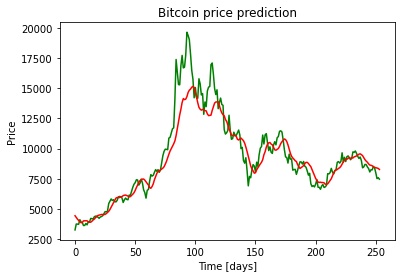

In [ ]:
twoLayer_LSTM = tf.keras.Sequential()
twoLayer_LSTM.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, 1),dropout=DROPOUT, return_sequences=True))
twoLayer_LSTM.add(tf.keras.layers.LSTM(WINDOW_SIZE,dropout=DROPOUT))
  
twoLayer_LSTM.add(tf.keras.layers.Dense(1, activation='linear'))
twoLayer_LSTM.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE), 
    loss="mse")
history_twoLayer_LSTM = twoLayer_LSTM.fit(
  np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
  y_train, 
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS, 
  verbose=VERBOSE, 
  validation_split=0.2)
model_evaluation(history_twoLayer_LSTM, twoLayer_LSTM, scaler, X_test, X_train, y_train, y_test)

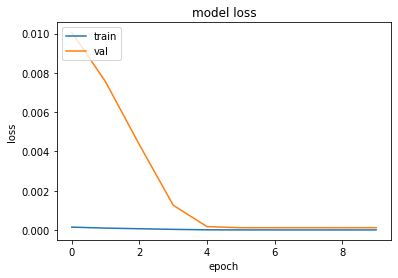

Train Score: 0.0003 RMSE
Test Score: 0.0590 RMSE


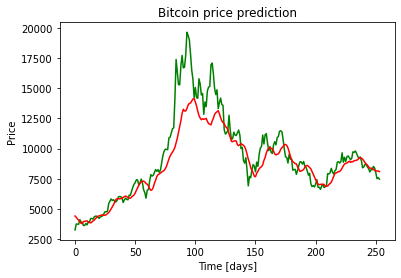

In [ ]:
twoLayer_LSTM = tf.keras.Sequential()
twoLayer_LSTM.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, 1),dropout=DROPOUT, return_sequences=True))
twoLayer_LSTM.add(tf.keras.layers.LSTM(2 * WINDOW_SIZE, dropout=DROPOUT))
  
twoLayer_LSTM.add(tf.keras.layers.Dense(1, activation='linear'))
twoLayer_LSTM.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE), 
    loss="mse")
history_twoLayer_LSTM = twoLayer_LSTM.fit(
  np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
  y_train, 
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS, 
  verbose=VERBOSE, 
  validation_split=0.2)
model_evaluation(history_twoLayer_LSTM, twoLayer_LSTM, scaler, X_test, X_train, y_train, y_test)

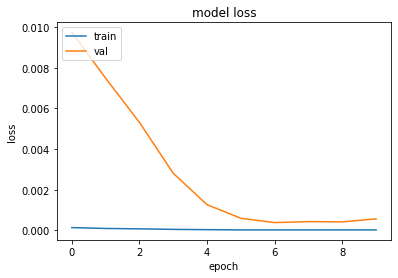

Train Score: 0.0000 RMSE
Test Score: 0.0162 RMSE


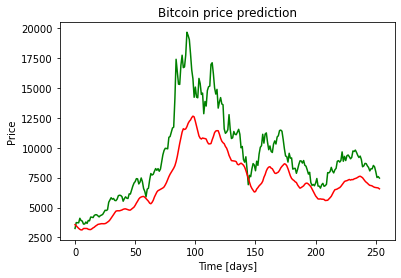

In [ ]:
twoLayer_LSTM = tf.keras.Sequential()
twoLayer_LSTM.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, 1),dropout=0.2, return_sequences=True))
twoLayer_LSTM.add(tf.keras.layers.LSTM(2 * WINDOW_SIZE,dropout=0.2))
  
twoLayer_LSTM.add(tf.keras.layers.Dense(1, activation='linear'))
twoLayer_LSTM.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE), 
    loss="mse")
history_twoLayer_LSTM = twoLayer_LSTM.fit(
  np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
  y_train, 
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS, 
  verbose=VERBOSE, 
  validation_split=0.2)
model_evaluation(history_twoLayer_LSTM, twoLayer_LSTM, scaler, X_test, X_train, y_train, y_test)

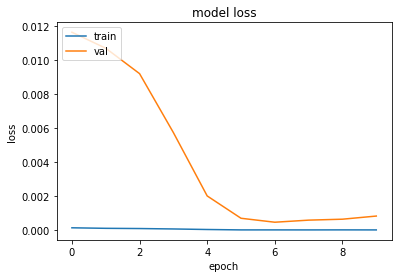

Train Score: 0.0002 RMSE
Test Score: 0.0073 RMSE


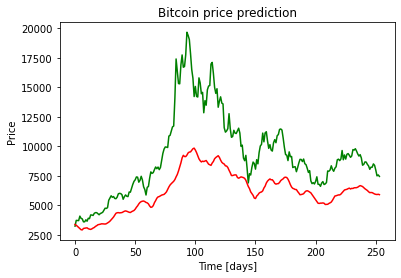

In [ ]:
tlstwoLayer_LSTM = tf.keras.Sequential()
twoLayer_LSTM.add(tf.keras.layers.LSTM(WINDOW_SIZE, input_shape=(WINDOW_SIZE, 1),dropout=0.2, return_sequences=True))
twoLayer_LSTM.add(tf.keras.layers.LSTM(2 * WINDOW_SIZE,dropout=0.2, return_sequences=True))
twoLayer_LSTM.add(tf.keras.layers.LSTM(WINDOW_SIZE))
  
twoLayer_LSTM.add(tf.keras.layers.Dense(1, activation='linear'))
twoLayer_LSTM.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE), 
    loss="mse")
history_twoLayer_LSTM = twoLayer_LSTM.fit(
  np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
  y_train, 
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS, 
  verbose=VERBOSE, 
  validation_split=0.2)
model_evaluation(history_twoLayer_LSTM, twoLayer_LSTM, scaler, X_test, X_train, y_train, y_test)

###Análise de Resultados

Nesses experimentos, observamos que a utilização de mais camadas LSTM não trazem muitas melhorias ao modelo. O modelo com 3 camadas apesar de aparentar o menor RMSE tem um gráfico que está longe do esperado. Enquanto isso, o modelo com 2 camadas mais simples teve o maior RMSE mas o gráfico foi o mais fidedigno. De qualquer forma, o modelo com 1 camada se mostrou mais adequado para este problema e com este conjunto de dados.